In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Loading images from data
# WIN path
#PATH = "C:/Users/Lenovo/Desktop/AI/AI_Project/data/"
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/data/"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('*/*/*.jpg')))
image_csv = pd.read_csv(PATH+'Raw_Data_JPG.csv')
CLASS_NAME = image_csv.Diagnosis.unique()
print(image_num)
print(CLASS_NAME)

5110
['No Finding' 'TB' 'Heart' 'CA lung' 'Intra' 'Extra']


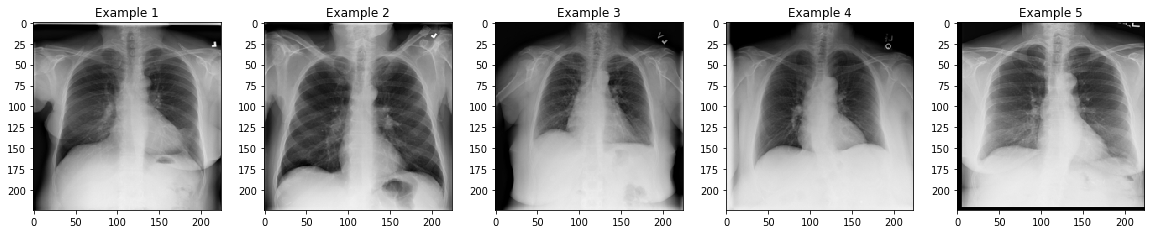

In [3]:
example_NoF = list(data_dir.glob('train/No Finding/*.jpg'))
i = 1
plt.figure(figsize=(20,20))
for n in example_NoF[:5]:
    ex = Image.open(n)
    ex_ar = np.asarray(ex)
    plt.subplot(5,5,i)
    word = "Example "+ str(i)
    plt.title(word)
    plt.imshow(ex_ar)
    i+=1

In [4]:
#Preproccsing image data into ImageDataGenerator
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "/train/"
TEST_PATH = PATH + "/test/"

#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME))
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME))

x_train,y_train = next(data_gen_train)
x_test,y_test = next(data_gen_test)

Found 4088 images belonging to 6 classes.
Found 1022 images belonging to 6 classes.


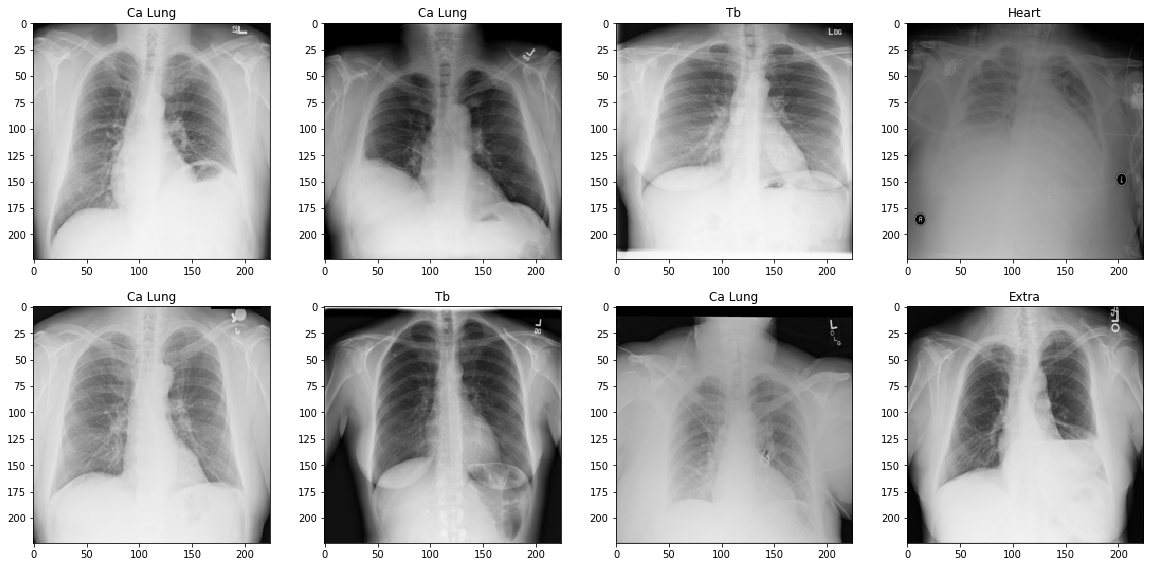

In [5]:
plt.figure(figsize=(20,20))
for n in range(8):
    plt.subplot(4,4,n+1)
    plt.title(CLASS_NAME[y_train[n]==1][0].title())
    plt.imshow(x_train[n])

In [7]:
#Try to load InceptionV3
myInception = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=6)
for layer in myInception.layers:
    layer.trainable = False

In [66]:
#Add layers configuration suitable for our model
#This is THE endgame for our project . Carefully review your stradigies 
# Current layers stacking is Awful . Inaccurate with fake accuracy

out = myInception.output
out = layers.GlobalAveragePooling2D()(out)
out = layers.Dense(1024,activation='relu')(out)
#out = layers.Dense(512,activation='relu')(out)
#out = layers.Dense(64,activation='relu')(out)
#out = layers.Dropout(0.2)(out)
out = layers.Dense(6,activation='softmax')(out)

myModel = Model(myInception.input,out)

In [67]:
#myModel.summary()

In [68]:
myModel.compile(loss='categorical_crossentropy',
                    optimizer='adamax',metrics=['accuracy'])

In [69]:
#Try to fit data into our model
STEP_PER_EPOCH = np.ceil(4088/32)
session = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_test,
                               epochs = 100,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = 30,
                               verbose = 1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128.0 steps, validate for 30 steps
Epoch 1/100
128/128 [==============================] - 17s 129ms/step - loss: 1.7441 - accuracy: 0.2573 - val_loss: 1.7985 - val_accuracy: 0.2417
Epoch 2/100
128/128 [==============================] - 12s 94ms/step - loss: 1.5331 - accuracy: 0.3635 - val_loss: 1.7521 - val_accuracy: 0.2510
Epoch 3/100
128/128 [==============================] - 12s 95ms/step - loss: 1.4603 - accuracy: 0.4132 - val_loss: 1.7848 - val_accuracy: 0.2406
Epoch 4/100
128/128 [==============================] - 12s 96ms/step - loss: 1.3936 - accuracy: 0.4369 - val_loss: 1.8783 - val_accuracy: 0.2281
Epoch 5/100
128/128 [==============================] - 12s 96ms/step - loss: 1.3208 - accuracy: 0.4807 - val_loss: 2.1996 - val_accuracy: 0.2250
Epoch 6/100
128/128 [==============================] - 12s 97ms/step - loss: 1.2778 - accuracy: 0.5037 - val_loss: 2.0577 - val_accuracy: 0.2177
Epoch 7/100
128/128 [=============

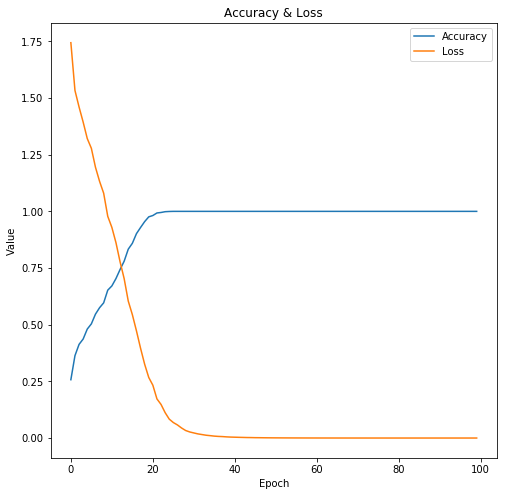

In [78]:
plt.figure(figsize=(8,8))
plt.plot(session.history['accuracy'])
plt.plot(session.history['loss'])
plt.title('Accuracy & Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'])
plt.savefig("Third Run.png")
plt.show()

In [71]:
STEP_PER_EPOCH = np.ceil(1022/32)
test_session = myModel.predict_generator(data_gen_test,STEP_PER_EPOCH)

Instructions for updating:
Please use Model.predict, which supports generators.


In [73]:
#num = 0
#for i in range(0,test_session.size):
#    if(test_session[i] > 0.5):
#        num+=1
#num

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [74]:
test_session

array([[8.4299554e-09, 9.9883181e-01, 9.9740501e-14, 3.5441233e-05,
        1.1164999e-03, 1.6216434e-05],
       [1.8901608e-14, 6.7114957e-02, 1.1219877e-09, 1.0633617e-08,
        9.3288499e-01, 7.3802639e-08],
       [9.8721078e-04, 7.4976557e-01, 1.0757882e-10, 2.4877843e-01,
        2.7755666e-05, 4.4107452e-04],
       ...,
       [6.8605920e-12, 9.5473303e-11, 2.5962007e-03, 1.9282736e-01,
        1.7397077e-04, 8.0440247e-01],
       [2.7457770e-11, 1.4471760e-12, 8.1227112e-01, 1.8772882e-01,
        1.4016609e-13, 6.0799884e-08],
       [5.6210760e-09, 7.9323745e-01, 5.1039844e-03, 1.7326383e-05,
        6.4618193e-04, 2.0099500e-01]], dtype=float32)